# HiggsML Classifier – CERN Open Data Project

This notebook implements a binary classification model to separate signal and background events using the Higgs Boson Challenge dataset.

Author: Ahmet Can Çömez

## Importing Required Libraries

This cell imports the essential libraries used throughout the project:

- `pandas` and `numpy` for data manipulation and numerical operations
- `matplotlib.pyplot` and `seaborn` for data visualization
- `scikit-learn` modules for data preprocessing, model training, and evaluation


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score

## Loading the Dataset

The dataset is loaded from a local CSV file.
We first inspect the shape of the data to understand the number of samples and features, and then display the first few rows using `head()` to preview the structure.


In [4]:
df = pd.read_csv('../data/training.csv')
print(f"shape of df: {df.shape}")
df.head()

shape of df: (250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


## Target Variable Encoding

The categorical target column `Label` is converted to binary numerical values:
- `'s'` (signal) → 1
- `'b'` (background) → 0

This transformation is required for compatibility with machine learning algorithms.
The updated distribution is reviewed to verify label encoding and assess class balance.


In [6]:
df['Label'] = df['Label'].map({'s': 1, 'b': 0})

## Dataset Overview

A concise summary of the dataset is obtained using `df.info()`.
This includes column data types, non-null counts, and memory usage.
The output is useful for detecting missing values and verifying dataset structure prior to preprocessing.


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

## Visualizing Class Distribution

This count plot displays the distribution of the target classes:
Signal (`1`) and Background (`0`).
It helps identify any class imbalance that may affect model performance.


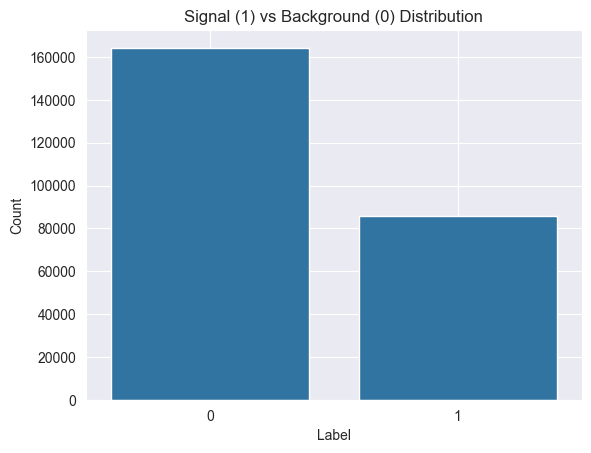

In [27]:
sns.countplot(x='Label', data=df)
plt.title("Signal (1) vs Background (0) Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()


## Feature and Target Definition

The dataset is split into input features (`X`) and target labels (`Y`).
The `Label`, `Weight`, and `EventId` columns are excluded from the feature matrix as they are either target indicators or metadata.
This step structures the data appropriately for supervised learning.


In [28]:
X = df.drop(['Label', 'Weight', 'EventId'], axis=1)
Y = df['Label']

        DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0            138.470                       51.655        97.827    27.980   
1            160.937                       68.768       103.235    48.146   
2           -999.000                      162.172       125.953    35.635   
3            143.905                       81.417        80.943     0.414   
4            175.864                       16.915       134.805    16.405   
...              ...                          ...           ...       ...   
249995      -999.000                       71.989        36.548     5.042   
249996      -999.000                       58.179        68.083    22.439   
249997       105.457                       60.526        75.839    39.757   
249998        94.951                       19.362        68.812    13.504   
249999      -999.000                       72.756        70.831     7.479   

        DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
0   

## Train-Test Split and Feature Scaling

The dataset is divided into training and testing subsets using an 80-20 split.
Feature standardization is then applied using `StandardScaler`, transforming the data to have zero mean and unit variance.
This preprocessing step is essential for optimizing the performance and stability of many machine learning algorithms, including gradient boosting.


In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Gradient Boosting Classifier Training

A `GradientBoostingClassifier` is instantiated with the following hyperparameters:
- `learning_rate = 0.1`
- `max_depth = 5`
- `n_estimators = 200`
- `subsample = 0.8`

The model is fitted on the standardized training data.
After training, class predictions (`y_pred`) and predicted probabilities (`y_score`) are computed on the test set for subsequent evaluation.


In [30]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

model.fit(X_train_scaled, Y_train)
y_pred = model.predict(X_test_scaled)
y_score = model.predict_proba(X_test_scaled)[:, 1]


## ROC Curve and AUC Score Evaluation

The Receiver Operating Characteristic (ROC) curve is generated to assess the model's classification performance.
The Area Under the Curve (AUC) is calculated to quantify the classifier's ability to distinguish between signal and background classes.
AUC values closer to 1.0 indicate strong predictive performance.


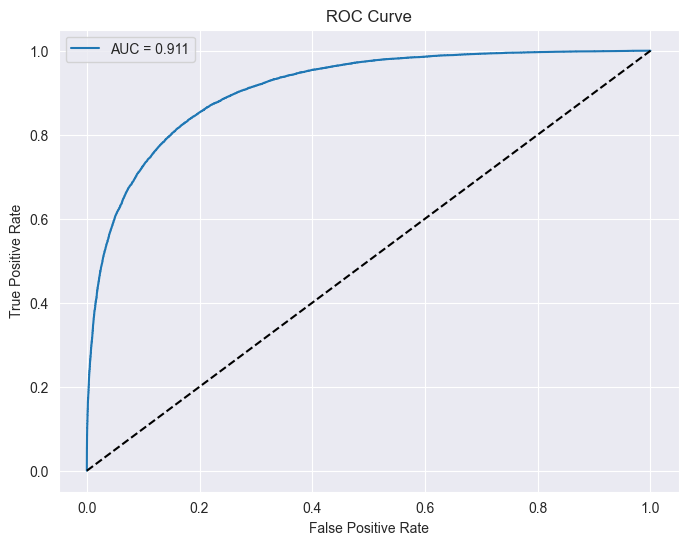

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(Y_test, y_score)
auc_score = roc_auc_score(Y_test, y_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## Confusion Matrix and Accuracy Score

The confusion matrix is computed to provide a detailed breakdown of prediction results, showing true positives, false positives, true negatives, and false negatives.
The accuracy score is also calculated to measure the overall proportion of correctly classified samples.
This evaluation helps in understanding the model’s performance beyond a single metric.


Accuracy: 0.8411


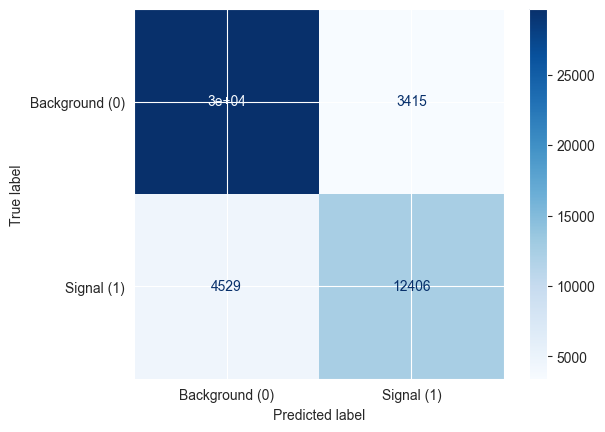

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background (0)", "Signal (1)"])
disp.plot(cmap='Blues')

acc = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {acc:.4f}")


## Saving the Trained Model

The trained `GradientBoostingClassifier` is serialized and saved using the `joblib` library.
This allows the model to be reloaded later for inference or integration into other systems without retraining.


In [35]:
import joblib

joblib.dump(model, "models/higgs_classifier.joblib")

['models/higgs_classifier.joblib']